# Determine the intrinsic parameters for the camera
I am using images from my Motorola z2 Force

Following: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration


In [1]:
import os
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt

Found 22 images


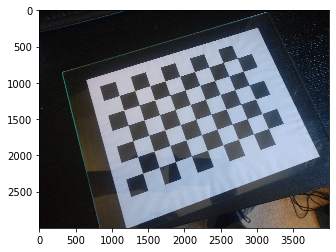

In [2]:
image_dir = "images/checkerboard/"
image_scale = 1.00
image_names = [os.path.join(image_dir,fname) for fname in os.listdir(image_dir)]
print(f"Found {len(image_names)} images")
images = [cv2.imread(fname) for fname in image_names]
if image_scale != 1:
    images = [cv2.resize(image,(0,0),fx=image_scale,fy=image_scale) for image in images]
plt.imshow(images[0][:,:,::-1])
plt.show()

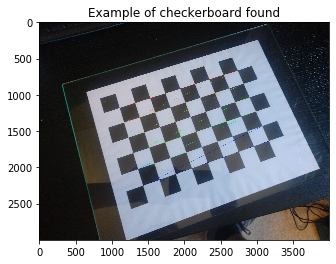

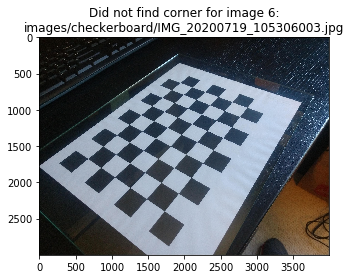

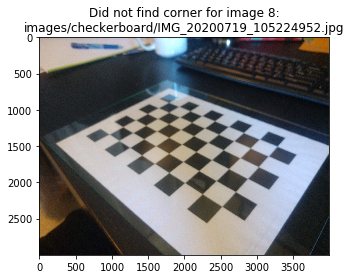

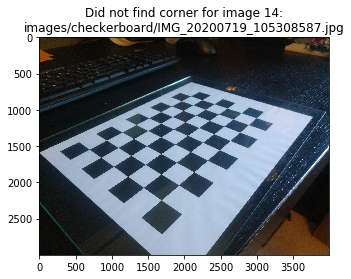

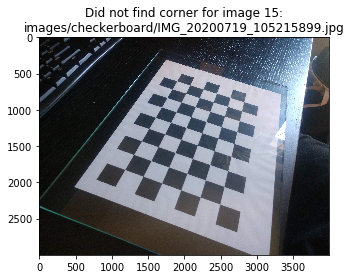

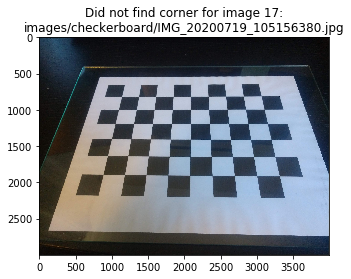

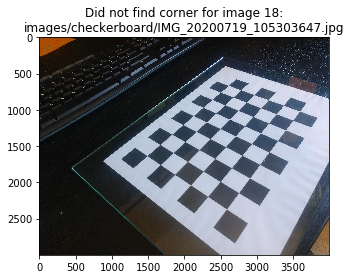

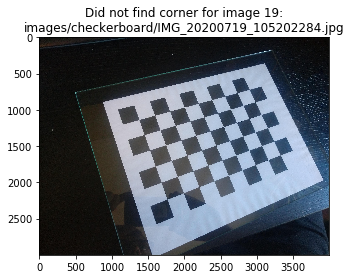

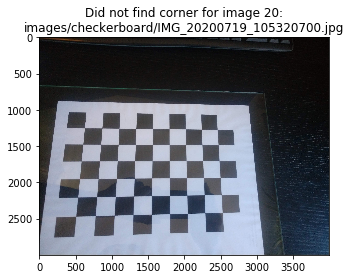

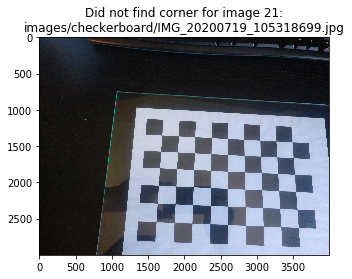

In [3]:
# Find the corners of the checkerboards
gridSize = (9,6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((gridSize[0]*gridSize[1],3),dtype=np.float32)
objp[:,:2] = np.mgrid[0:gridSize[0],0:gridSize[1]].T.reshape(-1,2)

objPoints = []
imgPoints = []
hasShownImage = False
for idx, image in enumerate(images):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, gridSize,None)
    if ret == True:
        objPoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(21,21),(-1,-1),criteria)
        imgPoints.append(corners2)
        
        if not hasShownImage:
            image_withCheckerboard = image.copy()
            image_withCheckerboard = cv2.drawChessboardCorners(image_withCheckerboard,gridSize,corners,ret)
            plt.title("Example of checkerboard found")
            plt.imshow(image_withCheckerboard[:,:,::-1])
            plt.show()
            hasShownImage = True
    else:
        plt.title(f"Did not find corner for image {idx}:\n{image_names[idx]}")
        plt.imshow(image[:,:,::-1])
        plt.show()
        

In [4]:
# Now calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1],None,None)
print(f"Calibration matrix:\n{mtx}")

Calibration matrix:
[[3.22981256e+03 0.00000000e+00 1.99150568e+03]
 [0.00000000e+00 3.21643202e+03 1.47577314e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [5]:
# Get the optimal calibration matrix
# Setting alpha=1 means the image will be expanded, setting it to 0 will crop off parts of the image
alpha = 0
h,w = images[0].shape[:2]
newCameraMtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),alpha,(w,h))
print(f"New Camera Matrix:\n{newCameraMtx}")
print(f"roi (height,width):\n\t    top left: ({roi[1]:4.0f},{roi[0]:4.0f})\n\tbottom right: ({roi[1]+roi[3]:4.0f},{roi[0]+roi[2]:4.0f})")

parameters = {"image_scale":image_scale,
              "image_shape_calibrated_on": images[0].shape,
              "mtx":mtx.tolist(),
              "newCameraMtx":newCameraMtx.tolist(),
              "dist":dist.tolist(),
             "roi":roi,
             "alpha":alpha}
              
parameter_filename = f"camera_parameters_scale{image_scale:.4f}.json"
with open(parameter_filename,'w') as fp:
    json.dump(parameters,fp,indent=2)
print(f"\nSaved parameters to {parameter_filename}")

New Camera Matrix:
[[3.29393652e+03 0.00000000e+00 2.00528826e+03]
 [0.00000000e+00 3.29044263e+03 1.47028860e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
roi (height,width):
	    top left: (   0,   0)
	bottom right: (2999,3999)

Saved parameters to camera_parameters_scale1.0000.json


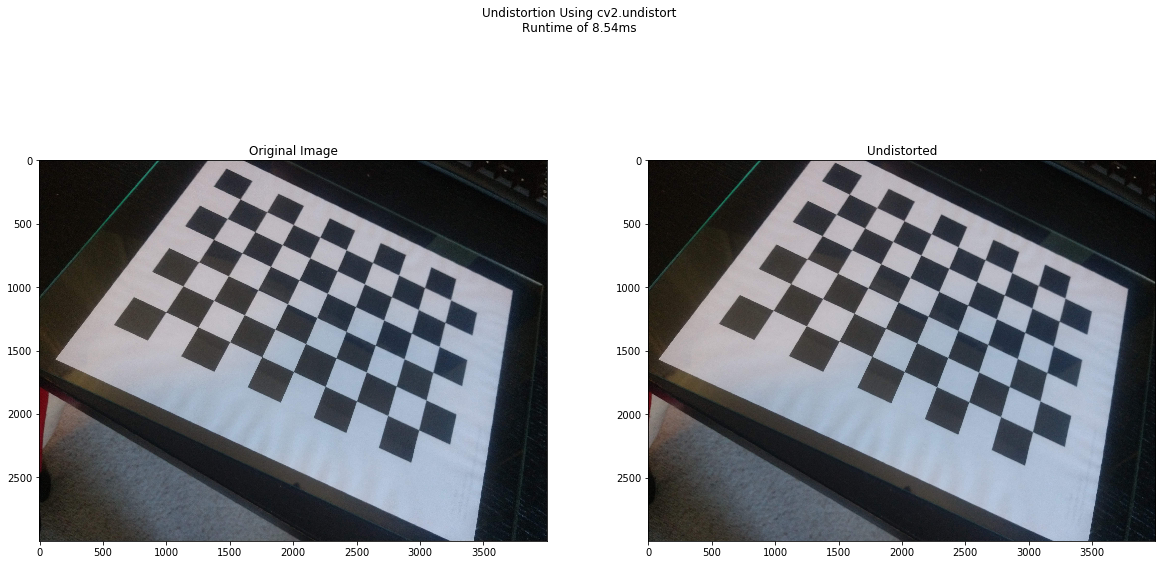

In [6]:
# Show an undistorted image
# This method is the simplist, but it is signficnatly slower than the other method
# Using %%timeit on just the undistort function:
#   8.54 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
plt.rcParams['figure.figsize'] = [20,10]
image = images[5]
dst = cv2.undistort(image, mtx, dist, None, newCameraMtx)
x,y,w,h = roi
dst = dst[y:y+h,x:x+w]
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image[:,:,::-1])
plt.subplot(1,2,2)
plt.title("Undistorted")
plt.imshow(dst[:,:,::-1])
plt.suptitle(f"Undistortion Using cv2.undistort\nRuntime of 8.54ms")
plt.show()

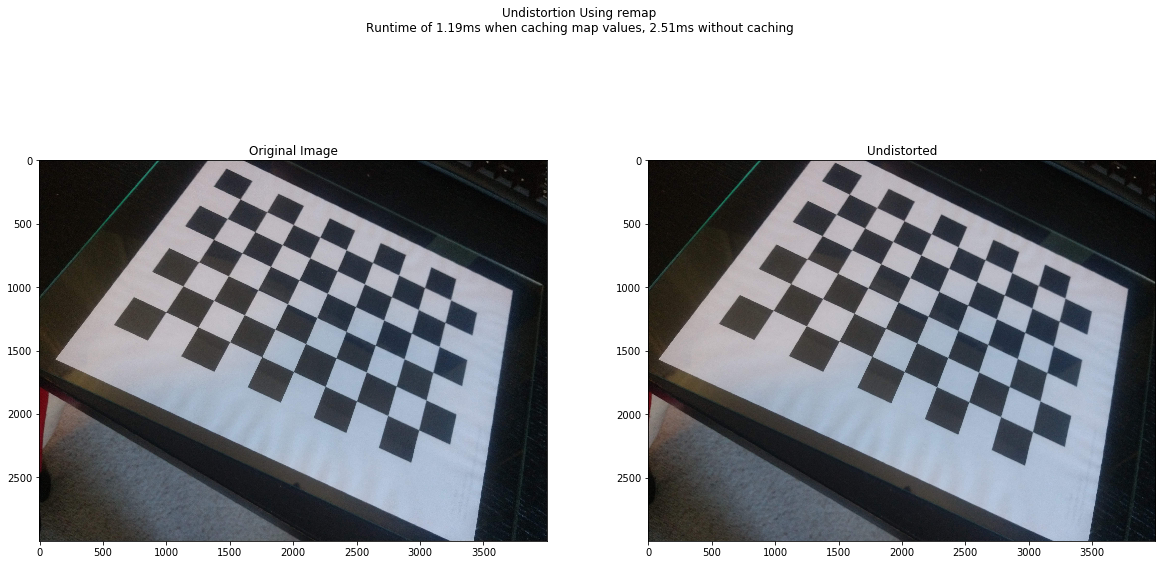

In [7]:
# Undistort using the remap function
# Note that the mapx and mapy values do not depend on the image itself,
#    so they can be calculated at the start and just re-used later
# Timing for running both initUndistortRectifyMap:
#    2.51 ms ± 52.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# Timing for running just remap:
#    1.19 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# By caching map values, we get a speed up of ~8x

plt.rcParams['figure.figsize'] = [20,10]
image = images[5]
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newCameraMtx,(w,h),5)
dst = cv2.remap(image,mapx,mapy,cv2.INTER_LINEAR)
x,y,w,h = roi
dst = dst[y:y+h,x:x+w]
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image[:,:,::-1])
plt.subplot(1,2,2)
plt.title("Undistorted")
plt.imshow(dst[:,:,::-1])
plt.suptitle("Undistortion Using remap\nRuntime of 1.19ms when caching map values, 2.51ms without caching")
plt.show()